In [1]:
# First download punblicly available synthea dataset and uzip it

!wget https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
!unzip synthea_sample_data_csv_apr2020.zip


In [1]:
import pandas as pd

df = pd.read_csv('csv/patients.csv')
df.drop(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'ADDRESS', 'LAST', 'SUFFIX', 'MAIDEN','LAT', 'LON',], axis=1, inplace=True)
print(df.columns)

Index(['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE',
       'COUNTY', 'ZIP', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')


Next, read patients data and remove fields such as id, date, SSN, name etc. Note, that we are trying to generate synthetic data which can be used to train our deep learning models for some other tasks. For such a model, we don't require fields like id, date, SSN etc.

In [2]:
# data configuration


file_name = "csv/patients.csv"
columns_to_drop = ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'ADDRESS', 'LAST', 'SUFFIX', 'MAIDEN','LAT', 'LON']
categorical_features = ['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE', 'COUNTY', 'ZIP']
continuous_features = ['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']
col1, col2 = 'num_of_doors', 'price'
col_group_by = 'body_style'

# training configuration
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

In [3]:
import pandas as pd

df = pd.read_csv(file_name)
df.drop(columns_to_drop, axis=1, inplace=True)
print(df.columns)

Index(['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE',
       'COUNTY', 'ZIP', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')


In [4]:
#Next, we will encode all categorical features to integer values. We are simply encoding the features to numerical values and are not using one hot encoding as its not required for GANs.



for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes

df.head()

,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,0,4,0,1,136,42,0,6,2,271227.08,1334.88
1,0,4,1,1,61,186,0,8,132,793946.01,3204.49
2,0,4,1,1,236,42,0,6,3,574111.90,2606.40
3,0,4,1,0,291,110,0,8,68,935630.30,8756.19
4,-1,4,1,1,189,24,0,12,125,598763.07,3772.20


In [5]:
#Next, we will encode all continious features to equally sized bins. First, lets find the minimum and maximum values for HEALTHCARE_EXPENSES and HEALTHCARE_COVERAGE and then create bins based on these values.

import numpy as np

for column in continuous_features:
  min = df[column].min()
  max = df[column].max()
  feature_bins = pd.cut(df[column], bins=np.linspace(min, max, 21), labels=False)
  df.drop([column], axis=1, inplace=True)
  df = pd.concat([df, feature_bins], axis=1)
  print(df)

      MARITAL  RACE  ETHNICITY  GENDER  BIRTHPLACE  CITY  STATE  COUNTY  ZIP  \
0           0     4          0       1         136    42      0       6    2   
1           0     4          1       1          61   186      0       8  132   
2           0     4          1       1         236    42      0       6    3   
3           0     4          1       0         291   110      0       8   68   
4          -1     4          1       1         189    24      0      12  125   
...       ...   ...        ...     ...         ...   ...    ...     ...  ...   
1166        0     0          0       0         112    33      0       8  130   
1167        1     4          1       1         255    21      0       4   80   
1168        1     4          1       0          76   154      0      10   -1   
1169        0     4          1       0         236   154      0      10   98   
1170        0     4          1       0         289   154      0      10  102   

      HEALTHCARE_COVERAGE  HEALTHCARE_E

Transform the data

Next, we apply PowerTransformer on all the fields to get a Gaussian distribution for the data.

In [6]:
from sklearn.preprocessing import PowerTransformer


df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

print(df)

       MARITAL      RACE  ETHNICITY    GENDER  BIRTHPLACE      CITY  STATE  \
0     0.334507  0.461541  -3.059874  1.040975    0.158023 -0.934665    0.0   
1     0.334507  0.461541   0.326811  1.040975   -0.743838  0.991601    0.0   
2     0.334507  0.461541   0.326811  1.040975    1.059635 -0.934665    0.0   
3     0.334507  0.461541   0.326811 -0.960637    1.482022  0.117825    0.0   
4    -1.275676  0.461541   0.326811  1.040975    0.662666 -1.324473    0.0   
...        ...       ...        ...       ...         ...       ...    ...   
1166  0.334507 -2.207146  -3.059874 -0.960637   -0.098914 -1.118375    0.0   
1167  1.773476  0.461541   0.326811  1.040975    1.210032 -1.400048    0.0   
1168  1.773476  0.461541   0.326811 -0.960637   -0.535455  0.646801    0.0   
1169  0.334507  0.461541   0.326811 -0.960637    1.059635  0.646801    0.0   
1170  0.334507  0.461541   0.326811 -0.960637    1.467316  0.646801    0.0   

        COUNTY       ZIP  HEALTHCARE_EXPENSES  HEALTHCARE_COVER

C:\Users\mithu\miniconda3\envs\dl\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [22]:
from sklearn.preprocessing import PowerTransformer


pw= PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
pwt=pw.fit_transform(df[df.columns])

print(df)

       MARITAL      RACE  ETHNICITY    GENDER  BIRTHPLACE      CITY  STATE  \
0     0.334507  0.461541  -3.059874  1.040975    0.158023 -0.934665    0.0   
1     0.334507  0.461541   0.326811  1.040975   -0.743838  0.991601    0.0   
2     0.334507  0.461541   0.326811  1.040975    1.059635 -0.934665    0.0   
3     0.334507  0.461541   0.326811 -0.960637    1.482022  0.117825    0.0   
4    -1.275676  0.461541   0.326811  1.040975    0.662666 -1.324473    0.0   
...        ...       ...        ...       ...         ...       ...    ...   
1166  0.334507 -2.207146  -3.059874 -0.960637   -0.098914 -1.118375    0.0   
1167  1.773476  0.461541   0.326811  1.040975    1.210032 -1.400048    0.0   
1168  1.773476  0.461541   0.326811 -0.960637   -0.535455  0.646801    0.0   
1169  0.334507  0.461541   0.326811 -0.960637    1.059635  0.646801    0.0   
1170  0.334507  0.461541   0.326811 -0.960637    1.467316  0.646801    0.0   

        COUNTY       ZIP  HEALTHCARE_EXPENSES  HEALTHCARE_COVER

C:\Users\mithu\miniconda3\envs\dl\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [23]:
df[df.columns]=pwt

In [8]:
df

,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,0.334507,0.461541,-3.059874,1.040975,0.158023,-0.934665,0.0,-0.526126,-0.334024,-0.819522,-0.187952
1,0.334507,0.461541,0.326811,1.040975,-0.743838,0.991601,0.0,-0.004130,1.084866,0.259373,-0.187952
2,0.334507,0.461541,0.326811,1.040975,1.059635,-0.934665,0.0,-0.526126,-0.245281,-0.111865,-0.187952
3,0.334507,0.461541,0.326811,-0.960637,1.482022,0.117825,0.0,-0.004130,0.796616,0.426979,-0.187952
4,-1.275676,0.461541,0.326811,1.040975,0.662666,-1.324473,0.0,1.084068,1.060350,-0.111865,-0.187952
...,...,...,...,...,...,...,...,...,...,...,...
1166,0.334507,-2.207146,-3.059874,-0.960637,-0.098914,-1.118375,0.0,-0.004130,1.077982,1.398831,-0.187952
1167,1.773476,0.461541,0.326811,1.040975,1.210032,-1.400048,0.0,-1.028657,0.865198,0.585251,-0.187952
1168,1.773476,0.461541,0.326811,-0.960637,-0.535455,0.646801,0.0,0.533442,-1.036576,1.275817,5.320497
1169,0.334507,0.461541,0.326811,-0.960637,1.059635,0.646801,0.0,0.533442,0.952695,1.016430,-0.187952


Next, lets define the neural network for generating synthetic data. We will be using a GAN network that comprises of an generator and discriminator that tries to beat each other and in the process learns the vector embedding for the data.

The model was taken from a Github repository where it is used to generate synthetic data on credit card fraud data.

In [24]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [25]:
data_cols = df.columns

In [26]:
#Define the GAN and training parameters
df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

11


In [12]:
# !mkdir model
# !mkdir model/gan
# !mkdir model/gan/saved

The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [27]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

0 [D loss: 0.676822, acc.: 45.31%] [G loss: 0.662941]
generated_data
1 [D loss: 0.642644, acc.: 50.00%] [G loss: 0.640900]
2 [D loss: 0.625779, acc.: 50.00%] [G loss: 0.624852]
3 [D loss: 0.593242, acc.: 50.00%] [G loss: 0.629532]
4 [D loss: 0.578762, acc.: 50.00%] [G loss: 0.655295]
5 [D loss: 0.537195, acc.: 50.00%] [G loss: 0.708575]
6 [D loss: 0.489928, acc.: 60.94%] [G loss: 0.785676]
7 [D loss: 0.454364, acc.: 78.12%] [G loss: 0.852673]
8 [D loss: 0.466511, acc.: 67.19%] [G loss: 0.858180]
9 [D loss: 0.483875, acc.: 57.81%] [G loss: 0.889254]
10 [D loss: 0.533286, acc.: 53.12%] [G loss: 0.844190]
11 [D loss: 0.601506, acc.: 48.44%] [G loss: 0.901749]
12 [D loss: 0.549050, acc.: 53.12%] [G loss: 0.998198]
13 [D loss: 0.455878, acc.: 87.50%] [G loss: 1.149815]
14 [D loss: 0.459629, acc.: 85.94%] [G loss: 1.295619]
15 [D loss: 0.475202, acc.: 82.81%] [G loss: 1.284856]
16 [D loss: 0.533237, acc.: 68.75%] [G loss: 1.189641]
17 [D loss: 0.629702, acc.: 57.81%] [G loss: 1.114784]
18 [D

151 [D loss: 0.252455, acc.: 92.19%] [G loss: 2.345118]
152 [D loss: 0.227604, acc.: 92.19%] [G loss: 2.321765]
153 [D loss: 0.244772, acc.: 92.19%] [G loss: 2.308035]
154 [D loss: 0.229997, acc.: 92.19%] [G loss: 2.416385]
155 [D loss: 0.226556, acc.: 92.19%] [G loss: 2.461457]
156 [D loss: 0.285188, acc.: 90.62%] [G loss: 2.686482]
157 [D loss: 0.288245, acc.: 87.50%] [G loss: 2.844541]
158 [D loss: 0.260719, acc.: 92.19%] [G loss: 2.992775]
159 [D loss: 0.314593, acc.: 92.19%] [G loss: 3.331412]
160 [D loss: 0.330104, acc.: 92.19%] [G loss: 3.408270]
161 [D loss: 0.516173, acc.: 79.69%] [G loss: 4.095533]
162 [D loss: 0.431447, acc.: 85.94%] [G loss: 3.343642]
163 [D loss: 0.657634, acc.: 67.19%] [G loss: 3.645575]
164 [D loss: 0.511177, acc.: 84.38%] [G loss: 3.774504]
165 [D loss: 0.474639, acc.: 84.38%] [G loss: 3.065371]
166 [D loss: 0.530119, acc.: 76.56%] [G loss: 3.705643]
167 [D loss: 0.365883, acc.: 87.50%] [G loss: 3.260273]
168 [D loss: 0.358383, acc.: 89.06%] [G loss: 2.

298 [D loss: 0.244453, acc.: 93.75%] [G loss: 2.665296]
299 [D loss: 0.307517, acc.: 92.19%] [G loss: 2.845500]
300 [D loss: 0.219141, acc.: 92.19%] [G loss: 2.815912]
generated_data
301 [D loss: 0.260153, acc.: 92.19%] [G loss: 2.436272]
302 [D loss: 0.223571, acc.: 93.75%] [G loss: 2.457398]
303 [D loss: 0.180221, acc.: 95.31%] [G loss: 2.564689]
304 [D loss: 0.166180, acc.: 96.88%] [G loss: 2.454525]
305 [D loss: 0.152586, acc.: 98.44%] [G loss: 2.458951]
306 [D loss: 0.164276, acc.: 96.88%] [G loss: 2.348035]
307 [D loss: 0.157560, acc.: 96.88%] [G loss: 2.168251]
308 [D loss: 0.175006, acc.: 96.88%] [G loss: 2.243910]
309 [D loss: 0.192410, acc.: 96.88%] [G loss: 2.218220]
310 [D loss: 0.221381, acc.: 96.88%] [G loss: 2.238924]
311 [D loss: 0.203185, acc.: 96.88%] [G loss: 2.261120]
312 [D loss: 0.304247, acc.: 90.62%] [G loss: 2.628431]
313 [D loss: 0.230211, acc.: 93.75%] [G loss: 2.616822]
314 [D loss: 0.360317, acc.: 87.50%] [G loss: 2.623740]
315 [D loss: 0.297431, acc.: 90.6

447 [D loss: 0.140166, acc.: 98.44%] [G loss: 2.649817]
448 [D loss: 0.164227, acc.: 96.88%] [G loss: 2.109673]
449 [D loss: 0.305580, acc.: 85.94%] [G loss: 2.102418]
450 [D loss: 0.303916, acc.: 90.62%] [G loss: 2.310626]
451 [D loss: 0.289936, acc.: 93.75%] [G loss: 2.331345]
452 [D loss: 0.289611, acc.: 92.19%] [G loss: 2.537964]
453 [D loss: 0.203578, acc.: 93.75%] [G loss: 2.951217]
454 [D loss: 0.198956, acc.: 92.19%] [G loss: 2.858400]
455 [D loss: 0.202141, acc.: 93.75%] [G loss: 2.904790]
456 [D loss: 0.192781, acc.: 95.31%] [G loss: 3.415874]
457 [D loss: 0.152835, acc.: 93.75%] [G loss: 3.624343]
458 [D loss: 0.169642, acc.: 95.31%] [G loss: 3.095323]
459 [D loss: 0.364929, acc.: 84.38%] [G loss: 4.536909]
460 [D loss: 0.256362, acc.: 87.50%] [G loss: 4.372355]
461 [D loss: 0.237549, acc.: 89.06%] [G loss: 3.217726]
462 [D loss: 0.209464, acc.: 92.19%] [G loss: 2.595729]
463 [D loss: 0.251189, acc.: 89.06%] [G loss: 4.264249]
464 [D loss: 0.177834, acc.: 90.62%] [G loss: 4.

593 [D loss: 0.278186, acc.: 89.06%] [G loss: 2.526172]
594 [D loss: 0.376461, acc.: 82.81%] [G loss: 2.300360]
595 [D loss: 0.305582, acc.: 87.50%] [G loss: 2.434676]
596 [D loss: 0.306420, acc.: 90.62%] [G loss: 2.606611]
597 [D loss: 0.299811, acc.: 90.62%] [G loss: 2.245359]
598 [D loss: 0.331685, acc.: 87.50%] [G loss: 2.327141]
599 [D loss: 0.289902, acc.: 90.62%] [G loss: 2.325922]
600 [D loss: 0.285872, acc.: 90.62%] [G loss: 2.110035]
generated_data
601 [D loss: 0.339612, acc.: 87.50%] [G loss: 2.275066]
602 [D loss: 0.263370, acc.: 90.62%] [G loss: 2.513970]
603 [D loss: 0.260578, acc.: 87.50%] [G loss: 2.548159]
604 [D loss: 0.216418, acc.: 90.62%] [G loss: 2.505454]
605 [D loss: 0.236768, acc.: 87.50%] [G loss: 2.389684]
606 [D loss: 0.276252, acc.: 87.50%] [G loss: 2.660067]
607 [D loss: 0.231572, acc.: 90.62%] [G loss: 2.854624]
608 [D loss: 0.216580, acc.: 92.19%] [G loss: 2.576172]
609 [D loss: 0.216226, acc.: 90.62%] [G loss: 2.416528]
610 [D loss: 0.205945, acc.: 92.1

739 [D loss: 0.213583, acc.: 92.19%] [G loss: 2.162723]
740 [D loss: 0.215879, acc.: 92.19%] [G loss: 2.087482]
741 [D loss: 0.204104, acc.: 93.75%] [G loss: 2.249715]
742 [D loss: 0.207827, acc.: 93.75%] [G loss: 2.039650]
743 [D loss: 0.224502, acc.: 92.19%] [G loss: 2.113369]
744 [D loss: 0.202417, acc.: 93.75%] [G loss: 2.019002]
745 [D loss: 0.197430, acc.: 93.75%] [G loss: 2.098564]
746 [D loss: 0.220372, acc.: 92.19%] [G loss: 2.142205]
747 [D loss: 0.197344, acc.: 92.19%] [G loss: 2.131257]
748 [D loss: 0.236251, acc.: 92.19%] [G loss: 2.126297]
749 [D loss: 0.220752, acc.: 92.19%] [G loss: 2.197434]
750 [D loss: 0.228134, acc.: 92.19%] [G loss: 2.103996]
751 [D loss: 0.209523, acc.: 92.19%] [G loss: 2.028212]
752 [D loss: 0.215623, acc.: 92.19%] [G loss: 2.038866]
753 [D loss: 0.229050, acc.: 92.19%] [G loss: 2.335670]
754 [D loss: 0.254868, acc.: 85.94%] [G loss: 2.383464]
755 [D loss: 0.222041, acc.: 92.19%] [G loss: 2.549055]
756 [D loss: 0.233289, acc.: 90.62%] [G loss: 2.

886 [D loss: 0.175320, acc.: 93.75%] [G loss: 2.310656]
887 [D loss: 0.165428, acc.: 93.75%] [G loss: 2.277046]
888 [D loss: 0.196818, acc.: 93.75%] [G loss: 2.165504]
889 [D loss: 0.193248, acc.: 93.75%] [G loss: 2.315818]
890 [D loss: 0.188022, acc.: 93.75%] [G loss: 2.422740]
891 [D loss: 0.188760, acc.: 93.75%] [G loss: 2.390021]
892 [D loss: 0.177039, acc.: 93.75%] [G loss: 2.436870]
893 [D loss: 0.176545, acc.: 93.75%] [G loss: 2.357332]
894 [D loss: 0.208101, acc.: 93.75%] [G loss: 2.156608]
895 [D loss: 0.203865, acc.: 93.75%] [G loss: 2.349258]
896 [D loss: 0.177501, acc.: 93.75%] [G loss: 2.352759]
897 [D loss: 0.208137, acc.: 93.75%] [G loss: 2.506479]
898 [D loss: 0.218363, acc.: 93.75%] [G loss: 2.359844]
899 [D loss: 0.218270, acc.: 92.19%] [G loss: 2.524940]
900 [D loss: 0.207458, acc.: 93.75%] [G loss: 2.358978]
generated_data
901 [D loss: 0.200340, acc.: 93.75%] [G loss: 2.503797]
902 [D loss: 0.199662, acc.: 93.75%] [G loss: 2.498322]
903 [D loss: 0.208241, acc.: 93.7

1034 [D loss: 0.164394, acc.: 93.75%] [G loss: 2.722063]
1035 [D loss: 0.179378, acc.: 93.75%] [G loss: 2.690787]
1036 [D loss: 0.162944, acc.: 93.75%] [G loss: 2.473814]
1037 [D loss: 0.162303, acc.: 93.75%] [G loss: 2.453058]
1038 [D loss: 0.157996, acc.: 95.31%] [G loss: 2.488454]
1039 [D loss: 0.181111, acc.: 95.31%] [G loss: 2.624316]
1040 [D loss: 0.188075, acc.: 93.75%] [G loss: 2.615147]
1041 [D loss: 0.171770, acc.: 93.75%] [G loss: 2.913820]
1042 [D loss: 0.152221, acc.: 95.31%] [G loss: 2.733790]
1043 [D loss: 0.193149, acc.: 93.75%] [G loss: 2.671406]
1044 [D loss: 0.170937, acc.: 95.31%] [G loss: 2.618585]
1045 [D loss: 0.176352, acc.: 93.75%] [G loss: 2.617159]
1046 [D loss: 0.188356, acc.: 95.31%] [G loss: 2.546430]
1047 [D loss: 0.171422, acc.: 95.31%] [G loss: 2.470323]
1048 [D loss: 0.182068, acc.: 93.75%] [G loss: 2.766337]
1049 [D loss: 0.201243, acc.: 93.75%] [G loss: 2.823062]
1050 [D loss: 0.162505, acc.: 95.31%] [G loss: 2.923043]
1051 [D loss: 0.176826, acc.: 9

1178 [D loss: 0.223865, acc.: 90.62%] [G loss: 2.532567]
1179 [D loss: 0.268841, acc.: 87.50%] [G loss: 2.720349]
1180 [D loss: 0.228063, acc.: 90.62%] [G loss: 2.597700]
1181 [D loss: 0.252014, acc.: 87.50%] [G loss: 2.559086]
1182 [D loss: 0.189762, acc.: 92.19%] [G loss: 2.270820]
1183 [D loss: 0.196964, acc.: 90.62%] [G loss: 2.128003]
1184 [D loss: 0.217476, acc.: 93.75%] [G loss: 2.330824]
1185 [D loss: 0.235786, acc.: 90.62%] [G loss: 2.562990]
1186 [D loss: 0.218574, acc.: 89.06%] [G loss: 2.382711]
1187 [D loss: 0.208428, acc.: 90.62%] [G loss: 2.281678]
1188 [D loss: 0.233446, acc.: 89.06%] [G loss: 2.547001]
1189 [D loss: 0.214339, acc.: 89.06%] [G loss: 2.415685]
1190 [D loss: 0.212629, acc.: 92.19%] [G loss: 2.510419]
1191 [D loss: 0.222733, acc.: 89.06%] [G loss: 2.599048]
1192 [D loss: 0.209907, acc.: 92.19%] [G loss: 2.683446]
1193 [D loss: 0.188252, acc.: 93.75%] [G loss: 2.493608]
1194 [D loss: 0.255988, acc.: 87.50%] [G loss: 2.831598]
1195 [D loss: 0.240626, acc.: 9

1322 [D loss: 0.224503, acc.: 90.62%] [G loss: 2.584700]
1323 [D loss: 0.222750, acc.: 90.62%] [G loss: 2.532394]
1324 [D loss: 0.212143, acc.: 90.62%] [G loss: 2.514611]
1325 [D loss: 0.198345, acc.: 93.75%] [G loss: 2.751316]
1326 [D loss: 0.262623, acc.: 85.94%] [G loss: 2.836352]
1327 [D loss: 0.236169, acc.: 90.62%] [G loss: 2.587216]
1328 [D loss: 0.217604, acc.: 87.50%] [G loss: 2.728163]
1329 [D loss: 0.259680, acc.: 85.94%] [G loss: 2.689225]
1330 [D loss: 0.207435, acc.: 89.06%] [G loss: 2.576393]
1331 [D loss: 0.186970, acc.: 92.19%] [G loss: 2.760263]
1332 [D loss: 0.204312, acc.: 92.19%] [G loss: 2.562320]
1333 [D loss: 0.194293, acc.: 89.06%] [G loss: 2.755937]
1334 [D loss: 0.223106, acc.: 87.50%] [G loss: 2.478955]
1335 [D loss: 0.229246, acc.: 87.50%] [G loss: 2.512680]
1336 [D loss: 0.207852, acc.: 90.62%] [G loss: 2.608844]
1337 [D loss: 0.223581, acc.: 87.50%] [G loss: 2.510378]
1338 [D loss: 0.246811, acc.: 89.06%] [G loss: 2.844848]
1339 [D loss: 0.223186, acc.: 9

1469 [D loss: 0.200935, acc.: 92.19%] [G loss: 2.806294]
1470 [D loss: 0.216187, acc.: 92.19%] [G loss: 2.557498]
1471 [D loss: 0.212338, acc.: 90.62%] [G loss: 2.864798]
1472 [D loss: 0.221169, acc.: 90.62%] [G loss: 2.948061]
1473 [D loss: 0.226156, acc.: 89.06%] [G loss: 2.946394]
1474 [D loss: 0.275853, acc.: 89.06%] [G loss: 3.382871]
1475 [D loss: 0.208750, acc.: 92.19%] [G loss: 2.926632]
1476 [D loss: 0.202553, acc.: 92.19%] [G loss: 2.921308]
1477 [D loss: 0.218532, acc.: 90.62%] [G loss: 2.707642]
1478 [D loss: 0.183103, acc.: 93.75%] [G loss: 3.024158]
1479 [D loss: 0.268017, acc.: 85.94%] [G loss: 2.843892]
1480 [D loss: 0.213732, acc.: 90.62%] [G loss: 3.208294]
1481 [D loss: 0.219162, acc.: 90.62%] [G loss: 2.631534]
1482 [D loss: 0.187884, acc.: 92.19%] [G loss: 2.573903]
1483 [D loss: 0.154699, acc.: 93.75%] [G loss: 2.720175]
1484 [D loss: 0.223983, acc.: 89.06%] [G loss: 2.435440]
1485 [D loss: 0.189955, acc.: 92.19%] [G loss: 2.693690]
1486 [D loss: 0.231306, acc.: 8

1616 [D loss: 0.220503, acc.: 84.38%] [G loss: 2.509659]
1617 [D loss: 0.212524, acc.: 89.06%] [G loss: 2.946438]
1618 [D loss: 0.203260, acc.: 90.62%] [G loss: 2.822297]
1619 [D loss: 0.237143, acc.: 92.19%] [G loss: 2.739192]
1620 [D loss: 0.229967, acc.: 90.62%] [G loss: 2.958695]
1621 [D loss: 0.245553, acc.: 89.06%] [G loss: 3.017958]
1622 [D loss: 0.208560, acc.: 90.62%] [G loss: 3.135919]
1623 [D loss: 0.185320, acc.: 92.19%] [G loss: 2.557218]
1624 [D loss: 0.175332, acc.: 92.19%] [G loss: 2.876842]
1625 [D loss: 0.202312, acc.: 95.31%] [G loss: 3.276179]
1626 [D loss: 0.199806, acc.: 93.75%] [G loss: 3.098157]
1627 [D loss: 0.268567, acc.: 89.06%] [G loss: 3.236370]
1628 [D loss: 0.210606, acc.: 89.06%] [G loss: 2.980594]
1629 [D loss: 0.173868, acc.: 92.19%] [G loss: 2.717010]
1630 [D loss: 0.234564, acc.: 89.06%] [G loss: 3.132800]
1631 [D loss: 0.225843, acc.: 92.19%] [G loss: 3.126682]
1632 [D loss: 0.228339, acc.: 92.19%] [G loss: 2.998011]
1633 [D loss: 0.184839, acc.: 9

1759 [D loss: 0.240948, acc.: 90.62%] [G loss: 2.532223]
1760 [D loss: 0.187782, acc.: 90.62%] [G loss: 2.807539]
1761 [D loss: 0.225500, acc.: 92.19%] [G loss: 2.754704]
1762 [D loss: 0.251674, acc.: 89.06%] [G loss: 3.453749]
1763 [D loss: 0.204783, acc.: 92.19%] [G loss: 2.687107]
1764 [D loss: 0.220423, acc.: 89.06%] [G loss: 2.719827]
1765 [D loss: 0.178584, acc.: 90.62%] [G loss: 2.583723]
1766 [D loss: 0.193166, acc.: 90.62%] [G loss: 2.849227]
1767 [D loss: 0.209802, acc.: 92.19%] [G loss: 2.996534]
1768 [D loss: 0.189698, acc.: 90.62%] [G loss: 2.870479]
1769 [D loss: 0.220670, acc.: 92.19%] [G loss: 2.785709]
1770 [D loss: 0.184184, acc.: 93.75%] [G loss: 3.111469]
1771 [D loss: 0.195364, acc.: 90.62%] [G loss: 2.757357]
1772 [D loss: 0.217047, acc.: 92.19%] [G loss: 2.976834]
1773 [D loss: 0.259260, acc.: 90.62%] [G loss: 2.863204]
1774 [D loss: 0.195687, acc.: 92.19%] [G loss: 2.539458]
1775 [D loss: 0.245864, acc.: 87.50%] [G loss: 2.708429]
1776 [D loss: 0.203953, acc.: 9

1903 [D loss: 0.204752, acc.: 93.75%] [G loss: 3.012107]
1904 [D loss: 0.193989, acc.: 92.19%] [G loss: 2.615480]
1905 [D loss: 0.171523, acc.: 93.75%] [G loss: 3.023839]
1906 [D loss: 0.221899, acc.: 89.06%] [G loss: 2.615951]
1907 [D loss: 0.180635, acc.: 92.19%] [G loss: 3.097538]
1908 [D loss: 0.227690, acc.: 90.62%] [G loss: 2.739310]
1909 [D loss: 0.219282, acc.: 89.06%] [G loss: 3.030734]
1910 [D loss: 0.213320, acc.: 90.62%] [G loss: 3.054606]
1911 [D loss: 0.204320, acc.: 90.62%] [G loss: 3.020321]
1912 [D loss: 0.258107, acc.: 90.62%] [G loss: 2.625292]
1913 [D loss: 0.255430, acc.: 90.62%] [G loss: 2.775203]
1914 [D loss: 0.191012, acc.: 93.75%] [G loss: 2.888201]
1915 [D loss: 0.202528, acc.: 90.62%] [G loss: 2.880820]
1916 [D loss: 0.214264, acc.: 89.06%] [G loss: 2.975913]
1917 [D loss: 0.223123, acc.: 90.62%] [G loss: 2.952111]
1918 [D loss: 0.189878, acc.: 90.62%] [G loss: 2.902881]
1919 [D loss: 0.221330, acc.: 93.75%] [G loss: 3.106540]
1920 [D loss: 0.146929, acc.: 9

2047 [D loss: 0.191975, acc.: 93.75%] [G loss: 2.922546]
2048 [D loss: 0.185475, acc.: 93.75%] [G loss: 2.944846]
2049 [D loss: 0.228728, acc.: 92.19%] [G loss: 3.070703]
2050 [D loss: 0.198076, acc.: 93.75%] [G loss: 3.183213]
2051 [D loss: 0.210555, acc.: 93.75%] [G loss: 3.086614]
2052 [D loss: 0.202171, acc.: 93.75%] [G loss: 2.906657]
2053 [D loss: 0.202208, acc.: 93.75%] [G loss: 3.220734]
2054 [D loss: 0.173248, acc.: 93.75%] [G loss: 3.264753]
2055 [D loss: 0.230993, acc.: 90.62%] [G loss: 2.879034]
2056 [D loss: 0.222349, acc.: 92.19%] [G loss: 2.530909]
2057 [D loss: 0.186460, acc.: 92.19%] [G loss: 2.850811]
2058 [D loss: 0.175017, acc.: 87.50%] [G loss: 2.909884]
2059 [D loss: 0.166055, acc.: 95.31%] [G loss: 3.160247]
2060 [D loss: 0.249226, acc.: 92.19%] [G loss: 2.846183]
2061 [D loss: 0.216168, acc.: 90.62%] [G loss: 2.888421]
2062 [D loss: 0.180085, acc.: 93.75%] [G loss: 2.687363]
2063 [D loss: 0.197173, acc.: 90.62%] [G loss: 2.653302]
2064 [D loss: 0.169885, acc.: 9

2193 [D loss: 0.181582, acc.: 92.19%] [G loss: 2.599467]
2194 [D loss: 0.241038, acc.: 89.06%] [G loss: 3.059426]
2195 [D loss: 0.180261, acc.: 93.75%] [G loss: 3.310329]
2196 [D loss: 0.183068, acc.: 93.75%] [G loss: 2.960070]
2197 [D loss: 0.211839, acc.: 93.75%] [G loss: 2.649631]
2198 [D loss: 0.156066, acc.: 93.75%] [G loss: 3.102090]
2199 [D loss: 0.191280, acc.: 92.19%] [G loss: 2.710766]
2200 [D loss: 0.192957, acc.: 90.62%] [G loss: 3.209710]
generated_data
2201 [D loss: 0.178893, acc.: 92.19%] [G loss: 2.967055]
2202 [D loss: 0.168641, acc.: 93.75%] [G loss: 2.907547]
2203 [D loss: 0.191214, acc.: 93.75%] [G loss: 2.905464]
2204 [D loss: 0.206790, acc.: 93.75%] [G loss: 2.977443]
2205 [D loss: 0.211962, acc.: 93.75%] [G loss: 2.915644]
2206 [D loss: 0.206156, acc.: 89.06%] [G loss: 2.877639]
2207 [D loss: 0.186661, acc.: 93.75%] [G loss: 3.029986]
2208 [D loss: 0.148452, acc.: 93.75%] [G loss: 2.899581]
2209 [D loss: 0.244840, acc.: 92.19%] [G loss: 3.045990]
2210 [D loss: 0.

2337 [D loss: 0.157800, acc.: 93.75%] [G loss: 3.555608]
2338 [D loss: 0.167195, acc.: 95.31%] [G loss: 2.986961]
2339 [D loss: 0.253926, acc.: 89.06%] [G loss: 3.071901]
2340 [D loss: 0.177936, acc.: 93.75%] [G loss: 3.269940]
2341 [D loss: 0.170640, acc.: 95.31%] [G loss: 2.972674]
2342 [D loss: 0.155226, acc.: 95.31%] [G loss: 2.682166]
2343 [D loss: 0.191618, acc.: 92.19%] [G loss: 2.919527]
2344 [D loss: 0.239195, acc.: 89.06%] [G loss: 3.512115]
2345 [D loss: 0.219636, acc.: 90.62%] [G loss: 3.409125]
2346 [D loss: 0.205600, acc.: 90.62%] [G loss: 2.653157]
2347 [D loss: 0.203718, acc.: 90.62%] [G loss: 2.667425]
2348 [D loss: 0.207377, acc.: 92.19%] [G loss: 2.767521]
2349 [D loss: 0.198786, acc.: 93.75%] [G loss: 3.172176]
2350 [D loss: 0.179602, acc.: 92.19%] [G loss: 2.870659]
2351 [D loss: 0.232500, acc.: 89.06%] [G loss: 3.040327]
2352 [D loss: 0.184793, acc.: 89.06%] [G loss: 3.386891]
2353 [D loss: 0.281050, acc.: 87.50%] [G loss: 3.062752]
2354 [D loss: 0.219781, acc.: 9

2484 [D loss: 0.177162, acc.: 95.31%] [G loss: 2.823704]
2485 [D loss: 0.221628, acc.: 92.19%] [G loss: 2.816759]
2486 [D loss: 0.157754, acc.: 93.75%] [G loss: 3.373863]
2487 [D loss: 0.206427, acc.: 92.19%] [G loss: 2.518339]
2488 [D loss: 0.166543, acc.: 95.31%] [G loss: 2.914578]
2489 [D loss: 0.171396, acc.: 95.31%] [G loss: 3.053786]
2490 [D loss: 0.183822, acc.: 92.19%] [G loss: 2.785276]
2491 [D loss: 0.156109, acc.: 95.31%] [G loss: 2.826704]
2492 [D loss: 0.187608, acc.: 92.19%] [G loss: 2.953102]
2493 [D loss: 0.191404, acc.: 92.19%] [G loss: 2.628802]
2494 [D loss: 0.157005, acc.: 92.19%] [G loss: 2.887132]
2495 [D loss: 0.179269, acc.: 95.31%] [G loss: 2.728932]
2496 [D loss: 0.206005, acc.: 90.62%] [G loss: 3.349644]
2497 [D loss: 0.215997, acc.: 90.62%] [G loss: 2.792641]
2498 [D loss: 0.202292, acc.: 93.75%] [G loss: 3.029006]
2499 [D loss: 0.184770, acc.: 93.75%] [G loss: 3.092315]
2500 [D loss: 0.176751, acc.: 93.75%] [G loss: 3.227364]
generated_data
2501 [D loss: 0.

2629 [D loss: 0.152812, acc.: 95.31%] [G loss: 3.410864]
2630 [D loss: 0.179906, acc.: 93.75%] [G loss: 2.965764]
2631 [D loss: 0.207058, acc.: 93.75%] [G loss: 2.959008]
2632 [D loss: 0.180991, acc.: 93.75%] [G loss: 2.891646]
2633 [D loss: 0.190431, acc.: 93.75%] [G loss: 2.787603]
2634 [D loss: 0.209120, acc.: 90.62%] [G loss: 2.881807]
2635 [D loss: 0.170327, acc.: 95.31%] [G loss: 2.728409]
2636 [D loss: 0.177898, acc.: 92.19%] [G loss: 2.614364]
2637 [D loss: 0.216383, acc.: 87.50%] [G loss: 3.194046]
2638 [D loss: 0.189173, acc.: 95.31%] [G loss: 2.957227]
2639 [D loss: 0.200932, acc.: 92.19%] [G loss: 2.680606]
2640 [D loss: 0.153845, acc.: 95.31%] [G loss: 2.452678]
2641 [D loss: 0.137598, acc.: 95.31%] [G loss: 2.791056]
2642 [D loss: 0.187360, acc.: 95.31%] [G loss: 3.007771]
2643 [D loss: 0.166435, acc.: 93.75%] [G loss: 3.323748]
2644 [D loss: 0.164737, acc.: 92.19%] [G loss: 3.509980]
2645 [D loss: 0.208121, acc.: 93.75%] [G loss: 3.056004]
2646 [D loss: 0.154199, acc.: 9

2772 [D loss: 0.168705, acc.: 95.31%] [G loss: 2.885105]
2773 [D loss: 0.291659, acc.: 90.62%] [G loss: 2.951814]
2774 [D loss: 0.176465, acc.: 93.75%] [G loss: 2.977088]
2775 [D loss: 0.237335, acc.: 90.62%] [G loss: 3.072278]
2776 [D loss: 0.228653, acc.: 90.62%] [G loss: 2.964403]
2777 [D loss: 0.157319, acc.: 95.31%] [G loss: 2.607695]
2778 [D loss: 0.195258, acc.: 93.75%] [G loss: 2.543152]
2779 [D loss: 0.221139, acc.: 90.62%] [G loss: 2.916550]
2780 [D loss: 0.183988, acc.: 95.31%] [G loss: 3.027460]
2781 [D loss: 0.303285, acc.: 85.94%] [G loss: 3.090205]
2782 [D loss: 0.229266, acc.: 92.19%] [G loss: 3.073098]
2783 [D loss: 0.244914, acc.: 90.62%] [G loss: 2.770400]
2784 [D loss: 0.194949, acc.: 92.19%] [G loss: 2.778437]
2785 [D loss: 0.175198, acc.: 93.75%] [G loss: 2.983017]
2786 [D loss: 0.165803, acc.: 93.75%] [G loss: 2.735092]
2787 [D loss: 0.159997, acc.: 95.31%] [G loss: 2.751481]
2788 [D loss: 0.198214, acc.: 93.75%] [G loss: 2.691382]
2789 [D loss: 0.160697, acc.: 9

2915 [D loss: 0.201739, acc.: 92.19%] [G loss: 3.019060]
2916 [D loss: 0.191020, acc.: 93.75%] [G loss: 2.816886]
2917 [D loss: 0.179921, acc.: 93.75%] [G loss: 3.125059]
2918 [D loss: 0.218717, acc.: 92.19%] [G loss: 2.781520]
2919 [D loss: 0.174957, acc.: 93.75%] [G loss: 2.674954]
2920 [D loss: 0.212676, acc.: 95.31%] [G loss: 2.945921]
2921 [D loss: 0.175101, acc.: 95.31%] [G loss: 3.005756]
2922 [D loss: 0.158223, acc.: 95.31%] [G loss: 3.047641]
2923 [D loss: 0.175478, acc.: 93.75%] [G loss: 2.747452]
2924 [D loss: 0.141189, acc.: 95.31%] [G loss: 2.881771]
2925 [D loss: 0.190715, acc.: 93.75%] [G loss: 2.548242]
2926 [D loss: 0.148054, acc.: 95.31%] [G loss: 2.756680]
2927 [D loss: 0.138732, acc.: 93.75%] [G loss: 3.043324]
2928 [D loss: 0.183292, acc.: 95.31%] [G loss: 2.813293]
2929 [D loss: 0.177965, acc.: 95.31%] [G loss: 2.738007]
2930 [D loss: 0.166408, acc.: 93.75%] [G loss: 3.051729]
2931 [D loss: 0.176412, acc.: 93.75%] [G loss: 3.557167]
2932 [D loss: 0.157140, acc.: 9

3059 [D loss: 0.162542, acc.: 95.31%] [G loss: 2.831188]
3060 [D loss: 0.160784, acc.: 95.31%] [G loss: 3.315554]
3061 [D loss: 0.164782, acc.: 95.31%] [G loss: 3.146957]
3062 [D loss: 0.161904, acc.: 95.31%] [G loss: 3.077628]
3063 [D loss: 0.182003, acc.: 93.75%] [G loss: 3.094856]
3064 [D loss: 0.180659, acc.: 95.31%] [G loss: 3.054544]
3065 [D loss: 0.184628, acc.: 93.75%] [G loss: 2.758636]
3066 [D loss: 0.201760, acc.: 92.19%] [G loss: 2.722279]
3067 [D loss: 0.145064, acc.: 95.31%] [G loss: 3.372639]
3068 [D loss: 0.195547, acc.: 92.19%] [G loss: 3.057760]
3069 [D loss: 0.147238, acc.: 95.31%] [G loss: 2.890115]
3070 [D loss: 0.177289, acc.: 95.31%] [G loss: 2.811175]
3071 [D loss: 0.166715, acc.: 93.75%] [G loss: 2.855968]
3072 [D loss: 0.174488, acc.: 93.75%] [G loss: 3.707420]
3073 [D loss: 0.165727, acc.: 93.75%] [G loss: 3.275404]
3074 [D loss: 0.226276, acc.: 93.75%] [G loss: 2.986487]
3075 [D loss: 0.132350, acc.: 95.31%] [G loss: 3.491756]
3076 [D loss: 0.150387, acc.: 9

3205 [D loss: 0.141091, acc.: 95.31%] [G loss: 3.392805]
3206 [D loss: 0.178701, acc.: 95.31%] [G loss: 2.784760]
3207 [D loss: 0.220966, acc.: 93.75%] [G loss: 3.191514]
3208 [D loss: 0.165038, acc.: 93.75%] [G loss: 3.247540]
3209 [D loss: 0.172585, acc.: 95.31%] [G loss: 2.875423]
3210 [D loss: 0.183430, acc.: 92.19%] [G loss: 3.344539]
3211 [D loss: 0.218308, acc.: 93.75%] [G loss: 3.002678]
3212 [D loss: 0.170697, acc.: 95.31%] [G loss: 2.787153]
3213 [D loss: 0.241101, acc.: 92.19%] [G loss: 3.167063]
3214 [D loss: 0.178489, acc.: 93.75%] [G loss: 3.735004]
3215 [D loss: 0.188707, acc.: 93.75%] [G loss: 3.127728]
3216 [D loss: 0.144030, acc.: 95.31%] [G loss: 2.821305]
3217 [D loss: 0.180429, acc.: 93.75%] [G loss: 2.961745]
3218 [D loss: 0.177607, acc.: 95.31%] [G loss: 2.863879]
3219 [D loss: 0.176249, acc.: 93.75%] [G loss: 2.928059]
3220 [D loss: 0.258144, acc.: 90.62%] [G loss: 3.150644]
3221 [D loss: 0.167344, acc.: 92.19%] [G loss: 3.050965]
3222 [D loss: 0.185829, acc.: 9

3351 [D loss: 0.151380, acc.: 95.31%] [G loss: 2.796909]
3352 [D loss: 0.142261, acc.: 95.31%] [G loss: 3.217343]
3353 [D loss: 0.179257, acc.: 95.31%] [G loss: 2.914738]
3354 [D loss: 0.177262, acc.: 95.31%] [G loss: 2.963011]
3355 [D loss: 0.159453, acc.: 95.31%] [G loss: 2.861078]
3356 [D loss: 0.168020, acc.: 93.75%] [G loss: 3.346997]
3357 [D loss: 0.139738, acc.: 95.31%] [G loss: 3.267825]
3358 [D loss: 0.210616, acc.: 93.75%] [G loss: 2.875315]
3359 [D loss: 0.144646, acc.: 95.31%] [G loss: 2.829127]
3360 [D loss: 0.183415, acc.: 95.31%] [G loss: 2.971408]
3361 [D loss: 0.200132, acc.: 90.62%] [G loss: 3.099749]
3362 [D loss: 0.166719, acc.: 93.75%] [G loss: 2.818279]
3363 [D loss: 0.147528, acc.: 93.75%] [G loss: 2.661205]
3364 [D loss: 0.178441, acc.: 95.31%] [G loss: 3.100656]
3365 [D loss: 0.180380, acc.: 93.75%] [G loss: 3.202363]
3366 [D loss: 0.150273, acc.: 95.31%] [G loss: 2.658529]
3367 [D loss: 0.160899, acc.: 95.31%] [G loss: 2.673534]
3368 [D loss: 0.218831, acc.: 9

3498 [D loss: 0.157584, acc.: 93.75%] [G loss: 3.424541]
3499 [D loss: 0.146080, acc.: 95.31%] [G loss: 3.130705]
3500 [D loss: 0.169726, acc.: 95.31%] [G loss: 3.003349]
generated_data
3501 [D loss: 0.183187, acc.: 93.75%] [G loss: 3.251176]
3502 [D loss: 0.181080, acc.: 92.19%] [G loss: 3.062005]
3503 [D loss: 0.177725, acc.: 95.31%] [G loss: 3.299909]
3504 [D loss: 0.183062, acc.: 95.31%] [G loss: 2.671970]
3505 [D loss: 0.155548, acc.: 95.31%] [G loss: 2.806175]
3506 [D loss: 0.145748, acc.: 93.75%] [G loss: 3.414947]
3507 [D loss: 0.168248, acc.: 95.31%] [G loss: 2.842736]
3508 [D loss: 0.172274, acc.: 95.31%] [G loss: 2.963758]
3509 [D loss: 0.196170, acc.: 93.75%] [G loss: 3.010238]
3510 [D loss: 0.138221, acc.: 95.31%] [G loss: 3.663898]
3511 [D loss: 0.191860, acc.: 93.75%] [G loss: 2.704679]
3512 [D loss: 0.138298, acc.: 95.31%] [G loss: 2.935313]
3513 [D loss: 0.206023, acc.: 93.75%] [G loss: 2.559902]
3514 [D loss: 0.141169, acc.: 95.31%] [G loss: 3.380303]
3515 [D loss: 0.

3644 [D loss: 0.149240, acc.: 95.31%] [G loss: 2.774065]
3645 [D loss: 0.179788, acc.: 93.75%] [G loss: 2.730072]
3646 [D loss: 0.183839, acc.: 90.62%] [G loss: 2.866562]
3647 [D loss: 0.221601, acc.: 93.75%] [G loss: 3.024890]
3648 [D loss: 0.213599, acc.: 92.19%] [G loss: 2.740368]
3649 [D loss: 0.170958, acc.: 92.19%] [G loss: 2.890026]
3650 [D loss: 0.268485, acc.: 90.62%] [G loss: 2.981146]
3651 [D loss: 0.192833, acc.: 93.75%] [G loss: 3.125616]
3652 [D loss: 0.194959, acc.: 93.75%] [G loss: 2.858369]
3653 [D loss: 0.187573, acc.: 95.31%] [G loss: 2.787950]
3654 [D loss: 0.188222, acc.: 93.75%] [G loss: 3.114941]
3655 [D loss: 0.242548, acc.: 90.62%] [G loss: 3.104506]
3656 [D loss: 0.195704, acc.: 93.75%] [G loss: 2.723173]
3657 [D loss: 0.176973, acc.: 95.31%] [G loss: 2.877906]
3658 [D loss: 0.168238, acc.: 93.75%] [G loss: 2.843286]
3659 [D loss: 0.160000, acc.: 95.31%] [G loss: 2.881440]
3660 [D loss: 0.187248, acc.: 93.75%] [G loss: 2.679211]
3661 [D loss: 0.170734, acc.: 9

3792 [D loss: 0.175564, acc.: 93.75%] [G loss: 3.149957]
3793 [D loss: 0.167469, acc.: 95.31%] [G loss: 3.031628]
3794 [D loss: 0.162564, acc.: 93.75%] [G loss: 3.001873]
3795 [D loss: 0.143592, acc.: 95.31%] [G loss: 3.488679]
3796 [D loss: 0.174526, acc.: 93.75%] [G loss: 2.950318]
3797 [D loss: 0.224668, acc.: 92.19%] [G loss: 3.115939]
3798 [D loss: 0.199877, acc.: 93.75%] [G loss: 2.975807]
3799 [D loss: 0.211688, acc.: 93.75%] [G loss: 2.904016]
3800 [D loss: 0.176887, acc.: 93.75%] [G loss: 2.975534]
generated_data
3801 [D loss: 0.181808, acc.: 93.75%] [G loss: 3.047889]
3802 [D loss: 0.197138, acc.: 92.19%] [G loss: 3.094790]
3803 [D loss: 0.208787, acc.: 92.19%] [G loss: 3.218105]
3804 [D loss: 0.219238, acc.: 93.75%] [G loss: 2.724353]
3805 [D loss: 0.191515, acc.: 93.75%] [G loss: 2.822476]
3806 [D loss: 0.170315, acc.: 95.31%] [G loss: 2.785054]
3807 [D loss: 0.151423, acc.: 95.31%] [G loss: 3.101121]
3808 [D loss: 0.163702, acc.: 95.31%] [G loss: 2.735932]
3809 [D loss: 0.

3939 [D loss: 0.155238, acc.: 95.31%] [G loss: 2.829620]
3940 [D loss: 0.160521, acc.: 95.31%] [G loss: 3.210632]
3941 [D loss: 0.167943, acc.: 95.31%] [G loss: 3.116725]
3942 [D loss: 0.142643, acc.: 95.31%] [G loss: 3.251152]
3943 [D loss: 0.154344, acc.: 95.31%] [G loss: 3.044895]
3944 [D loss: 0.160017, acc.: 95.31%] [G loss: 3.153050]
3945 [D loss: 0.244351, acc.: 92.19%] [G loss: 2.803316]
3946 [D loss: 0.224813, acc.: 92.19%] [G loss: 3.004728]
3947 [D loss: 0.228497, acc.: 92.19%] [G loss: 3.071746]
3948 [D loss: 0.200886, acc.: 92.19%] [G loss: 3.171251]
3949 [D loss: 0.180193, acc.: 95.31%] [G loss: 3.362297]
3950 [D loss: 0.145109, acc.: 95.31%] [G loss: 3.014625]
3951 [D loss: 0.152740, acc.: 95.31%] [G loss: 2.684675]
3952 [D loss: 0.170565, acc.: 93.75%] [G loss: 3.015874]
3953 [D loss: 0.123252, acc.: 95.31%] [G loss: 3.371390]
3954 [D loss: 0.200223, acc.: 95.31%] [G loss: 2.404772]
3955 [D loss: 0.125481, acc.: 95.31%] [G loss: 3.750035]
3956 [D loss: 0.175347, acc.: 9

4086 [D loss: 0.139789, acc.: 95.31%] [G loss: 3.216723]
4087 [D loss: 0.156732, acc.: 95.31%] [G loss: 3.307383]
4088 [D loss: 0.174833, acc.: 93.75%] [G loss: 2.874613]
4089 [D loss: 0.179116, acc.: 93.75%] [G loss: 3.152277]
4090 [D loss: 0.142883, acc.: 93.75%] [G loss: 3.861498]
4091 [D loss: 0.185181, acc.: 95.31%] [G loss: 2.958036]
4092 [D loss: 0.228671, acc.: 93.75%] [G loss: 2.981199]
4093 [D loss: 0.167739, acc.: 95.31%] [G loss: 2.966295]
4094 [D loss: 0.202051, acc.: 93.75%] [G loss: 2.935139]
4095 [D loss: 0.175023, acc.: 95.31%] [G loss: 3.239101]
4096 [D loss: 0.160408, acc.: 95.31%] [G loss: 3.295672]
4097 [D loss: 0.172632, acc.: 95.31%] [G loss: 3.231211]
4098 [D loss: 0.148869, acc.: 95.31%] [G loss: 2.615261]
4099 [D loss: 0.155106, acc.: 95.31%] [G loss: 2.825152]
4100 [D loss: 0.148973, acc.: 93.75%] [G loss: 3.262426]
generated_data
4101 [D loss: 0.152521, acc.: 95.31%] [G loss: 3.612747]
4102 [D loss: 0.153545, acc.: 95.31%] [G loss: 2.772386]
4103 [D loss: 0.

4230 [D loss: 0.168865, acc.: 95.31%] [G loss: 3.141038]
4231 [D loss: 0.235109, acc.: 93.75%] [G loss: 2.743176]
4232 [D loss: 0.181776, acc.: 93.75%] [G loss: 2.601992]
4233 [D loss: 0.206751, acc.: 92.19%] [G loss: 2.484788]
4234 [D loss: 0.172381, acc.: 95.31%] [G loss: 2.642869]
4235 [D loss: 0.167042, acc.: 95.31%] [G loss: 2.718255]
4236 [D loss: 0.257179, acc.: 92.19%] [G loss: 2.714686]
4237 [D loss: 0.159669, acc.: 95.31%] [G loss: 3.137502]
4238 [D loss: 0.171735, acc.: 93.75%] [G loss: 2.687698]
4239 [D loss: 0.224217, acc.: 93.75%] [G loss: 2.863782]
4240 [D loss: 0.184618, acc.: 93.75%] [G loss: 2.849061]
4241 [D loss: 0.188974, acc.: 95.31%] [G loss: 2.982775]
4242 [D loss: 0.172584, acc.: 95.31%] [G loss: 3.309052]
4243 [D loss: 0.159216, acc.: 95.31%] [G loss: 2.993265]
4244 [D loss: 0.171808, acc.: 95.31%] [G loss: 2.598019]
4245 [D loss: 0.137734, acc.: 95.31%] [G loss: 2.909461]
4246 [D loss: 0.153339, acc.: 93.75%] [G loss: 3.232790]
4247 [D loss: 0.153534, acc.: 9

4378 [D loss: 0.151441, acc.: 95.31%] [G loss: 3.484259]
4379 [D loss: 0.169548, acc.: 95.31%] [G loss: 2.476792]
4380 [D loss: 0.141502, acc.: 95.31%] [G loss: 3.493213]
4381 [D loss: 0.136579, acc.: 95.31%] [G loss: 3.209952]
4382 [D loss: 0.156129, acc.: 95.31%] [G loss: 3.025383]
4383 [D loss: 0.147820, acc.: 95.31%] [G loss: 3.770895]
4384 [D loss: 0.154920, acc.: 93.75%] [G loss: 3.469298]
4385 [D loss: 0.159343, acc.: 95.31%] [G loss: 2.729282]
4386 [D loss: 0.139044, acc.: 95.31%] [G loss: 3.498157]
4387 [D loss: 0.154717, acc.: 93.75%] [G loss: 3.520923]
4388 [D loss: 0.178960, acc.: 95.31%] [G loss: 3.164046]
4389 [D loss: 0.126114, acc.: 95.31%] [G loss: 3.713347]
4390 [D loss: 0.166341, acc.: 95.31%] [G loss: 3.010035]
4391 [D loss: 0.176375, acc.: 93.75%] [G loss: 2.848789]
4392 [D loss: 0.158538, acc.: 95.31%] [G loss: 3.445500]
4393 [D loss: 0.143827, acc.: 95.31%] [G loss: 3.358794]
4394 [D loss: 0.171484, acc.: 95.31%] [G loss: 2.909859]
4395 [D loss: 0.173670, acc.: 9

4524 [D loss: 0.188948, acc.: 95.31%] [G loss: 2.758838]
4525 [D loss: 0.153636, acc.: 95.31%] [G loss: 3.202270]
4526 [D loss: 0.172858, acc.: 95.31%] [G loss: 2.921453]
4527 [D loss: 0.159903, acc.: 95.31%] [G loss: 2.693990]
4528 [D loss: 0.188525, acc.: 93.75%] [G loss: 3.240093]
4529 [D loss: 0.183061, acc.: 93.75%] [G loss: 2.939623]
4530 [D loss: 0.168570, acc.: 95.31%] [G loss: 3.025815]
4531 [D loss: 0.195799, acc.: 92.19%] [G loss: 3.727980]
4532 [D loss: 0.171092, acc.: 95.31%] [G loss: 3.233081]
4533 [D loss: 0.201210, acc.: 90.62%] [G loss: 2.461762]
4534 [D loss: 0.175554, acc.: 95.31%] [G loss: 2.908000]
4535 [D loss: 0.164245, acc.: 95.31%] [G loss: 2.996127]
4536 [D loss: 0.186946, acc.: 93.75%] [G loss: 3.185366]
4537 [D loss: 0.167635, acc.: 95.31%] [G loss: 2.632396]
4538 [D loss: 0.188373, acc.: 93.75%] [G loss: 3.027134]
4539 [D loss: 0.171913, acc.: 95.31%] [G loss: 2.887422]
4540 [D loss: 0.243801, acc.: 92.19%] [G loss: 3.020182]
4541 [D loss: 0.160935, acc.: 9

4668 [D loss: 0.170362, acc.: 95.31%] [G loss: 2.850452]
4669 [D loss: 0.155071, acc.: 95.31%] [G loss: 3.062909]
4670 [D loss: 0.143271, acc.: 95.31%] [G loss: 3.361370]
4671 [D loss: 0.158248, acc.: 95.31%] [G loss: 2.811626]
4672 [D loss: 0.143892, acc.: 95.31%] [G loss: 2.632456]
4673 [D loss: 0.160338, acc.: 93.75%] [G loss: 3.211039]
4674 [D loss: 0.156225, acc.: 95.31%] [G loss: 2.896992]
4675 [D loss: 0.192759, acc.: 93.75%] [G loss: 2.881449]
4676 [D loss: 0.153257, acc.: 95.31%] [G loss: 3.262537]
4677 [D loss: 0.167041, acc.: 93.75%] [G loss: 2.818805]
4678 [D loss: 0.170355, acc.: 93.75%] [G loss: 2.707154]
4679 [D loss: 0.165516, acc.: 93.75%] [G loss: 3.129184]
4680 [D loss: 0.162435, acc.: 95.31%] [G loss: 3.066239]
4681 [D loss: 0.166369, acc.: 95.31%] [G loss: 2.799641]
4682 [D loss: 0.189826, acc.: 93.75%] [G loss: 2.980146]
4683 [D loss: 0.153333, acc.: 95.31%] [G loss: 3.030020]
4684 [D loss: 0.167229, acc.: 93.75%] [G loss: 2.851995]
4685 [D loss: 0.176723, acc.: 9

4816 [D loss: 0.174142, acc.: 95.31%] [G loss: 2.676152]
4817 [D loss: 0.143824, acc.: 93.75%] [G loss: 3.416781]
4818 [D loss: 0.210128, acc.: 93.75%] [G loss: 3.288744]
4819 [D loss: 0.197555, acc.: 95.31%] [G loss: 2.624248]
4820 [D loss: 0.152590, acc.: 95.31%] [G loss: 2.957660]
4821 [D loss: 0.177679, acc.: 93.75%] [G loss: 3.279453]
4822 [D loss: 0.155221, acc.: 95.31%] [G loss: 2.790842]
4823 [D loss: 0.160287, acc.: 95.31%] [G loss: 2.882072]
4824 [D loss: 0.140653, acc.: 95.31%] [G loss: 3.562329]
4825 [D loss: 0.169307, acc.: 95.31%] [G loss: 3.097266]
4826 [D loss: 0.143776, acc.: 95.31%] [G loss: 3.046671]
4827 [D loss: 0.135927, acc.: 95.31%] [G loss: 3.022820]
4828 [D loss: 0.134714, acc.: 95.31%] [G loss: 3.282937]
4829 [D loss: 0.196430, acc.: 93.75%] [G loss: 3.146773]
4830 [D loss: 0.186119, acc.: 93.75%] [G loss: 3.622680]
4831 [D loss: 0.196033, acc.: 93.75%] [G loss: 3.171329]
4832 [D loss: 0.187036, acc.: 95.31%] [G loss: 2.518425]
4833 [D loss: 0.176829, acc.: 9

4961 [D loss: 0.151611, acc.: 95.31%] [G loss: 2.888065]
4962 [D loss: 0.148282, acc.: 95.31%] [G loss: 3.048382]
4963 [D loss: 0.177321, acc.: 95.31%] [G loss: 3.181022]
4964 [D loss: 0.192056, acc.: 93.75%] [G loss: 3.376420]
4965 [D loss: 0.173451, acc.: 95.31%] [G loss: 2.948910]
4966 [D loss: 0.155375, acc.: 95.31%] [G loss: 2.838145]
4967 [D loss: 0.175113, acc.: 95.31%] [G loss: 2.635291]
4968 [D loss: 0.148367, acc.: 95.31%] [G loss: 2.935454]
4969 [D loss: 0.156710, acc.: 95.31%] [G loss: 2.988550]
4970 [D loss: 0.152360, acc.: 95.31%] [G loss: 3.255716]
4971 [D loss: 0.143723, acc.: 95.31%] [G loss: 3.369333]
4972 [D loss: 0.171603, acc.: 95.31%] [G loss: 2.768929]
4973 [D loss: 0.149177, acc.: 95.31%] [G loss: 3.065334]
4974 [D loss: 0.162121, acc.: 95.31%] [G loss: 3.037390]
4975 [D loss: 0.156209, acc.: 95.31%] [G loss: 3.388630]
4976 [D loss: 0.143019, acc.: 95.31%] [G loss: 3.139423]
4977 [D loss: 0.154955, acc.: 95.31%] [G loss: 2.882811]
4978 [D loss: 0.141864, acc.: 9

In [14]:
#You can easily save the trained generator and loaded it aftwerwards

synthesizer.save('model/gan/saved', 'generator_patients')

In [15]:
#Lets look at discriminator model

synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense (Dense)                (32, 128)                 4224      
_________________________________________________________________
dense_1 (Dense)              (32, 256)                 33024     
_________________________________________________________________
dense_2 (Dense)              (32, 512)                 131584    
_________________________________________________________________
dense_3 (Dense)              (32, 11)                  5643      
Total params: 174,475
Trainable params: 174,475
Non-trainable params: 0
_________________________________________________________________


In [16]:
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 11)]                0         
_________________________________________________________________
dense_4 (Dense)              (32, 512)                 6144      
_________________________________________________________________
dropout (Dropout)            (32, 512)                 0         
_________________________________________________________________
dense_5 (Dense)              (32, 256)                 131328    
_________________________________________________________________
dropout_1 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dense_7 (Dense)              (32, 1)                   129 

Evaluation


Now, that we have trained the model let's see if the generated data is similar to the actual data.

We plot the generated data for some of the model steps and see how the plot for the generated data changes as the networks learns the embedding more accurately.

In [28]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

No handles with labels found to put in legend.


KeyError: "None of [Index(['num_of_doors'], dtype='object')] are in the [columns]"

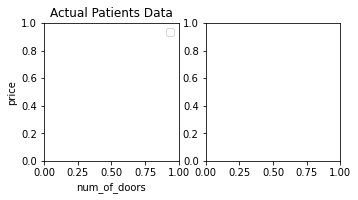

In [31]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
#     for group, color, marker in zip(real_samples.groupby(col_group_by), colors, markers):
#         plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Patients Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)

    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [30]:
g_z=pw.inverse_transform(g_z)
gen_samples = pd.DataFrame(g_z, columns=data_cols)
gen_samples.to_csv('Generated_sample.csv')

NameError: name 'g_z' is not defined

In [ ]:
# !pip install table_evaluator

In [ ]:
gen_samples.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_df.columns)
print(df.shape, gen_df.shape)

In [ ]:
from table_evaluator import load_data, TableEvaluator

print(len(df), len(gen_samples))
table_evaluator =  TableEvaluator(df, gen_samples)

table_evaluator.visual_evaluation()

Conclusion


Some of the features in the syntehtic data match closely with actual data but there are some other features which were not learnt perfectly by the model. We can keep playing with the model and its hyperparameters to improve the model further.

This post demonstrates that its fairly simply to use GANs to generate synthetic data where the actual data is sensitive in nature and can't be shared publicly.